## Feature Extraction and Exploratory Modeling


Here I will use the info gained during EDA to extract some potentially helpful features and create a rough-draft model.

---

**Imports**

In [19]:
# the classics
import pandas as pd
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
%matplotlib inline

# some specific data manipulation tools from sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# pipeline and gridsearch for tuning
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator

# a few models to try at first
# from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier

# model evaluation tools
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, make_scorer, recall_score, fbeta_score, accuracy_score

# natural language processing tools
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer;

from wbcustom.roc import plot as roc
from wbcustom.feature_extraction import FeatureExtraction
from wbcustom.nsfw_cleaner import NsfwCleaner

**Import the Data and drop nulls**

In [2]:
# read in all of the tweets
tweets = pd.read_csv('./assets/tweets.csv')

# drop tweets with any null values
tweets = tweets.dropna().reset_index(drop=True)

**Under Sample**

In an attempt to tune for recall without increasing variance, we will undersample the majority class (non-questionable) so that our positive class composition moves from 13% to ~50%

In [3]:
# split tweets by class
tweets0 = tweets[tweets['questionable_content'] == 0]
tweets1 = tweets[tweets['questionable_content'] == 1]

# from ~19k to 2k samples of not questionable tweets
tweets0 = tweets0.sample(n=2000, random_state=23)

tweets_rs = pd.concat(objs=[tweets0, tweets1])

In [4]:
# set X and y
X = tweets_rs['text']
y = tweets_rs['questionable_content']

**Lemmatize the Data**

---

This decision was made out of sake of eaze. We don't care as much about context/usage, and more about the core words. More investigation should be done on stemming/lemmatizing/etc. with slang. 

POS tagging should be used for better lemmatization

In [5]:
# use NLTK word net lemmatizer
lemmatizer = WordNetLemmatizer()
X_lem = [
    ' '.join([lemmatizer.lemmatize(word) for word in x.split(' ')]) for x in X
]

**Feature Extraction**

Function to detect suspect words given a corpus and a reference list. I think a lot of the model's power could come from different category scores that could be used in interaction terms. For  the sake of time, I ended up copying the list at [BannedWordList](http://www.bannedwordlist.com)

In [6]:
# define a list of NSFW words using feature improtances and www.bannedwordlist.com
# nsfw = ['anal', 'anus', 'arse', 'ass', 'ballsack', 'balls', 'bastard', 'bitch', 'bitches', 'biatch',
#                      'blowjob', 'boner', 'boob', 'butt', 'buttplug',
#                      'clitoris', 'cock', 'coon', 'crap', 'cunt', 'damn', 'dick', 'dildo', 'dyke', 'fag', 'faggot', 'feck',
#                      'fellate', 'fellatio', 'felching', 'fuck', 'fucking', 'fudgepacker', 'fudge packer', 'flange',
#                      'gay', 'Goddamn', 'God damn', 'hell', 'hoe', 'hoes', 'homo', 'jerk', 'jizz', 'knobend', 'knob end', 'labia',
#                      'lmfao', 'muff', 'nigger', 'niggers', 'nigga', 'niggah', 'niggas', 'niggaz', 'ngga', 'penis', 'piss', 'poop', 'prick', 'pube', 'pussy', 'pussi',
#                      'queer', 'retard', 'retarded', 'scrotum', 'shit', 's hit', 'sh1t', 'slut', 'sluts', 'smegma', 'spunk', 'tit', 'tosser',
#                      'turd', 'twat', 'vagina', 'wank', 'whore']

# words taken from https://github.com/LDNOOBW/List-of-Dirty-Naughty-Obscene-and-Otherwise-Bad-Words/
# I liked this list because it contains a larger variety of phrases
nsfw = ['2g1c', '2 girls 1 cup', 'acrotomophilia', 'alabama hot pocket', 'alaskan pipeline', 'anal', 'anilingus', 'anus', 'apeshit', 'arsehole', 'ass', 'asshole', 'assmunch', 'auto erotic', 'autoerotic', 'babeland', 'baby batter', 'baby juice', 'ball gag', 'ball gravy', 'ball kicking', 'ball licking', 'ball sack', 'ball sucking', 'bangbros', 'bareback', 'barely legal', 'barenaked', 'bastard', 'bastardo', 'bastinado', 'bbw', 'bdsm', 'beaner', 'beaners', 'beaver cleaver', 'beaver lips', 'bestiality', 'big black', 'big breasts', 'big knockers', 'big tits', 'bimbos', 'birdlock', 'bitch', 'bitches', 'black cock', 'blonde action', 'blonde on blonde action', 'blowjob', 'blow job', 'blow your load', 'blue waffle', 'blumpkin', 'bollocks', 'bondage', 'boner', 'boob', 'boobs', 'booty call', 'brown showers', 'brunette action', 'bukkake', 'bulldyke', 'bullet vibe', 'bullshit', 'bung hole', 'bunghole', 'busty', 'butt', 'buttcheeks', 'butthole', 'camel toe', 'camgirl', 'camslut', 'camwhore', 'carpet muncher', 'carpetmuncher', 'chocolate rosebuds', 'circlejerk', 'cleveland steamer', 'clit', 'clitoris', 'clover clamps', 'clusterfuck', 'cock', 'cocks', 'coprolagnia', 'coprophilia', 'cornhole', 'coon', 'coons', 'creampie', 'cum', 'cumming', 'cunnilingus', 'cunt', 'darkie', 'date rape', 'daterape', 'deep throat', 'deepthroat', 'dendrophilia', 'dick', 'dildo', 'dingleberry', 'dingleberries', 'dirty pillows', 'dirty sanchez', 'doggie style', 'doggiestyle', 'doggy style', 'doggystyle', 'dog style', 'dolcett', 'domination', 'dominatrix', 'dommes', 'donkey punch', 'double dong', 'double penetration', 'dp action', 'dry hump', 'dvda', 'eat my ass', 'ecchi', 'ejaculation', 'erotic', 'erotism', 'escort', 'eunuch', 'faggot', 'fecal', 'felch', 'fellatio', 'feltch', 'female squirting', 'femdom', 'figging', 'fingerbang', 'fingering', 'fisting', 'foot fetish', 'footjob', 'frotting', 'fuck', 'fuck buttons', 'fuckin', 'fucking', 'fucktards', 'fudge packer', 'fudgepacker', 'futanari', 'gang bang', 'gay sex', 'genitals', 'giant cock', 'girl on', 'girl on top', 'girls gone wild', 'goatcx', 'goatse', 'god damn', 'gokkun', 'golden shower', 'goodpoop', 'goo girl', 'goregasm', 'grope', 'group sex', 'g-spot', 'guro', 'hand job', 'handjob', 'hard core', 'hardcore', 'hentai', 'homoerotic', 'honkey', 'hooker', 'hot carl', 'hot chick', 'how to kill', 'how to murder', 'huge fat', 'humping', 'incest', 'intercourse', 'jack off', 'jail bait', 'jailbait', 'jelly donut', 'jerk off', 'jigaboo', 'jiggaboo', 'jiggerboo', 'jizz', 'juggs', 'kike', 'kinbaku', 'kinkster', 'kinky', 'knobbing', 'leather restraint', 'leather straight jacket', 'lemon party', 'lolita', 'lovemaking', 'make me come', 'male squirting', 'masturbate', 'menage a trois', 'milf', 'missionary position', 'motherfucker', 'mound of venus', 'mr hands', 'muff diver', 'muffdiving', 'nambla', 'nawashi', 'negro', 'neonazi', 'nigga', 'niggers', 'niggah', 'niggas', 'niggaz', 'ngga', 'nigger', 'nig nog', 'nimphomania', 'nipple', 'nipples', 'nsfw images', 'nude', 'nudity', 'nympho', 'nymphomania', 'octopussy', 'omorashi', 'one cup two girls', 'one guy one jar', 'orgasm', 'orgy', 'paedophile', 'paki', 'panties', 'panty', 'pedobear', 'pedophile', 'pegging', 'penis', 'phone sex', 'piece of shit', 'pissing', 'piss pig', 'pisspig', 'playboy', 'pleasure chest', 'pole smoker', 'ponyplay', 'poof', 'poon', 'poontang', 'punany', 'poop chute', 'poopchute', 'porn', 'porno', 'pornography', 'prince albert piercing', 'pthc', 'pubes', 'pussy', 'queaf', 'queef', 'quim', 'raghead', 'raging boner', 'rape', 'raping', 'rapist', 'rectum', 'reverse cowgirl', 'rimjob', 'rimming', 'rosy palm', 'rosy palm and her 5 sisters', 'rusty trombone', 'sadism', 'santorum', 'scat', 'schlong', 'scissoring', 'semen', 'sex', 'sexo', 'sexy', 'shaved beaver', 'shaved pussy', 'shemale', 'shibari', 'shit', 'shitblimp', 'shitty', 'shota', 'shrimping', 'skeet', 'slanteye', 'slut', 's&m', 'smut', 'snatch', 'snowballing', 'sodomize', 'sodomy', 'spic', 'splooge', 'splooge moose', 'spooge', 'spread legs', 'spunk', 'strap on', 'strapon', 'strappado', 'strip club', 'style doggy', 'suck', 'sucks', 'suicide girls', 'sultry women', 'swastika', 'swinger', 'tainted love', 'taste my', 'tea bagging', 'threesome', 'throating', 'tied up', 'tight white', 'tit', 'tits', 'titties', 'titty', 'tongue in a', 'topless', 'tosser', 'towelhead', 'tranny', 'tribadism', 'tub girl', 'tubgirl', 'tushy', 'twat', 'twink', 'twinkie', 'two girls one cup', 'undressing', 'upskirt', 'urethra play', 'urophilia', 'vagina', 'venus mound', 'vibrator', 'violet wand', 'vorarephilia', 'voyeur', 'vulva', 'wank', 'wetback', 'wet dream', 'white power', 'wrapping men', 'wrinkled starfish', 'xx', 'xxx', 'yaoi', 'yellow showers', 'yiffy', 'zoophilia', '🖕']

# empty list used to test effect of under sampling
# nsfw = []

In [7]:
# TTS
X_train, X_test, y_train, y_test = train_test_split(X_lem, y, test_size = .25, stratify = y, random_state = 23)

# fresh vectorizer instance
cvec = CountVectorizer()

X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

**Lets make a nsfw mask for the df**  
  
**THIS WOULD BE MUCH FASTER AS A PREPROCCESSING STEP**

In [8]:
# function for detecting presence of nsfw words
def nsfw_consolidation(vectorizer = cvec, sparse_matrix = X_train_cvec, nsfw = nsfw):
    # names of columns
    feature_names = vectorizer.get_feature_names()
    # locations of non-zero entries
    cx = sparse_matrix.tocoo()
    
    # blank return containers
    nsfw_columns = set()
    rows_to_filter = set()
    mask = [False]*sparse_matrix.shape[0]
    
    print('Looping non-zero entries')
    # column detector
    for i, column in enumerate(feature_names):
        [nsfw_columns.add(i) for word in nsfw if (word in column)]
    
    # row detector
    for nsfw_word in nsfw_columns:
        [rows_to_filter.add(i) for i, j in zip(cx.row, cx.col) if (j == nsfw_word)]
    
    print('Generating mask')
    
    # mask generator
    for row in rows_to_filter:
        mask[row] = True
    
    return (nsfw_columns, rows_to_filter, mask)
        
(nsfw_columns, rows_to_filter, nsfw_mask) = nsfw_consolidation(cvec, cvec.transform(X))

Looping non-zero entries
Generating mask


In [9]:
# turn in to a df for lazy column dropping
X_scrub = pd.DataFrame(cvec.transform(X).todense(), columns = cvec.get_feature_names())
X_scrub['contains_nsfw'] = np.where(nsfw_mask, 1, 0)

sia = SentimentIntensityAnalyzer()
vader = pd.DataFrame([sia.polarity_scores(x) for x in X])
X_scrub = pd.concat(objs=[X_scrub.reset_index(drop=True), vader], axis=1)



In [10]:
# drop columns, with status printout
for i, column in enumerate(X_scrub.columns):
    if i % 1000 == 0:
        print(column, i/len(X_scrub.columns))
    
    if i in nsfw_columns:
        X_scrub.drop([column], inplace=True, axis=1)


00 0.0
bangkok 0.09126585744273068
cnet 0.18306636155606407
día 0.27540622418066646
going 0.36812074360390207
jeffreygoldberg 0.4607870242373975
matthewcdoherty 0.5539654694857354
pants 0.6480881399870383
richraddon 0.743287187587104
status 0.8384572386808273
u26fd 0.934317481080071


In [11]:
labels = X_scrub.columns
# re-sparsify the matrix
X_scrub = sparse.csr_matrix(X_scrub.values)

# tts
X_train, X_test, y_train, y_test = train_test_split(X_scrub, y, test_size = .25, stratify = y, random_state = 23)

Undersampling alone can get us all the way up to a recall of ~.62 before we start seeing huge decreases in precision. Accuracy has taken a hit due to the lack of easy 0s to predict, but we see no signs of overfitting with train and test accuracies of .78 and .76.  Once we add the test feature extraction/elimination, recall is increased again to ~.72, depending on configuration, with accuracies hovering around .75 ~ .78.

I used VADER for quick sentiment scores. We get positive, neutral, and negative scores, as well as a compound score. This is another area that should be explored more (e.g. political sentiment could be implemented), interactions between sentiment and specific words. Only negative showed up in the 50 estimators used by stock adaboost

Below in the gridsearch, I tune using base estimators, number of estimators, and beta value for fbeta scoring.

In [12]:
# Quick Grid Search
be1 = DecisionTreeClassifier(max_depth=1)
be2 = LogisticRegression(C=.01)

params = {
    'base_estimator': [be1, be2],
    'n_estimators': [50, 60, 80]
}

scorers = {
    'fbeta': make_scorer(log_loss)
}

gridsearch = GridSearchCV(AdaBoostClassifier(), params, cv=5, verbose = 1, n_jobs=-1, scoring=scorers, refit='fbeta')


# so much for DRY
cvec_1e = CountVectorizer(stop_words='english')
cvec_1n = CountVectorizer()
# cvec_2e = CountVectorizer(ngram_range = (1,2), stop_words='english')
# cvec_2n = CountVectorizer(ngram_range = (1,2))

vecs = [cvec_1e]

for vec in vecs:

    # TTS
    X_train, X_test, y_train, y_test = train_test_split(X_lem, y, test_size = .25, stratify = y, random_state = 23)

    # fresh vectorizer instance
    cvec = vec

    X_train_cvec = cvec.fit_transform(X_train)
    X_test_cvec = cvec.transform(X_test)
    
    (_, _, nsfw_mask_train) = nsfw_consolidation(cvec, X_train_cvec)
    (_, _, nsfw_mask_test) = nsfw_consolidation(cvec, X_test_cvec)
    
    print('NSFW Consolidated')
    
    X_scrub_train = pd.DataFrame(X_train_cvec.todense(), columns = cvec.get_feature_names())
    X_scrub_test = pd.DataFrame(X_test_cvec.todense(), columns = cvec.get_feature_names())
    X_scrub_train['contains_nsfw'] = np.where(nsfw_mask_train, 1, 0)
    X_scrub_test['contains_nsfw'] = np.where(nsfw_mask_test, 1, 0)
    
    print('Analyzing Sentiment')
    
    sia = SentimentIntensityAnalyzer()
    vader_train = pd.DataFrame([sia.polarity_scores(x) for x in X_train])
    vader_test = pd.DataFrame([sia.polarity_scores(x) for x in X_test])
    X_scrub_train = pd.concat(objs=[X_scrub_train.reset_index(drop=True), vader_train], axis=1)
    X_scrub_test = pd.concat(objs=[X_scrub_test.reset_index(drop=True), vader_test], axis=1)
    
    print('Dropping NSFW')
    for i, column in enumerate(X_scrub_train.columns):
        if i % 2000 == 0:
            print('Through column ', column, i/len(X_scrub_train.columns))

        if i in nsfw_columns:
            X_scrub_train.drop([column], inplace=True, axis=1)
            X_scrub_test.drop([column], inplace=True, axis=1)

    labels = X_scrub_train.columns
    # re-sparsify the matrix
    X_scrub_train = sparse.csr_matrix(X_scrub_train.values)
    X_scrub_test = sparse.csr_matrix(X_scrub_test.values)
    
    print('GridSearching')
    gs = gridsearch.fit(X_scrub_train, y_train)

    print('Train Score: ', gs.score(X_scrub_train, y_train))
    print('Test Score: ', gs.score(X_scrub_test, y_test))
    
    # get feature importances from the model, plot
    print(classification_report(y_test, gs.predict(X_scrub_test)))
    print('---')

    # use the classification report function for more classification metrics
    confusion_matrix(y_test, gs.predict(X_scrub_test))

    print(gs.best_params_)

Looping non-zero entries
Generating mask
Looping non-zero entries
Generating mask
NSFW Consolidated
Analyzing Sentiment
Dropping NSFW
Through column  00 0.0
Through column  comin 0.1874062968515742
Through column  graphic 0.3768962593046264
Through column  meridiantdiv 0.5672149744753261
Through column  rylandr5 0.7611798287345385
Through column  upsetting 0.9569377990430622
GridSearching
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.9s finished
/Users/teaching/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train Score:  14.105462561533166
Test Score:  14.097786119322807
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       500
           1       0.59      1.00      0.74       725

   micro avg       0.59      0.59      0.59      1225
   macro avg       0.30      0.50      0.37      1225
weighted avg       0.35      0.59      0.44      1225

---
{'base_estimator': LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), 'n_estimators': 50}


/Users/teaching/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Zeroing in

In [68]:

be1 = DecisionTreeClassifier(max_depth=1)
be2 = DecisionTreeClassifier(max_depth=2)

params = {
    'base_estimator': [be1],
    'n_estimators': [10,12,15,20,28,40, 60, 100],
}

scorers = {
    'recall': make_scorer(recall_score),
    'fbeta': make_scorer(fbeta_score, beta=1.1),
    'accuracy': make_scorer(accuracy_score)
}

gridsearch = GridSearchCV(AdaBoostClassifier(), params, cv=10, verbose = 1, n_jobs=-1, scoring=scorers, refit='fbeta')

gs = gridsearch.fit(X_scrub_train, y_train)

print('Train Score: ', gs.score(X_scrub_train, y_train))
print('Test Score: ', gs.score(X_scrub_test, y_test))

# get feature importances from the model, plot
print(classification_report(y_test, gs.predict(X_scrub_test)))
print('---')

# use the classification report function for more classification metrics
print(confusion_matrix(y_test, gs.predict(X_scrub_test)))

print(gs.best_params_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.3s


Train Score:  0.7506660048164774
Test Score:  0.7501667492157833
              precision    recall  f1-score   support

           0       0.64      0.75      0.69       500
           1       0.81      0.71      0.75       725

   micro avg       0.73      0.73      0.73      1225
   macro avg       0.72      0.73      0.72      1225
weighted avg       0.74      0.73      0.73      1225

---
[[377 123]
 [211 514]]
{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), 'n_estimators': 12}


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   14.3s finished


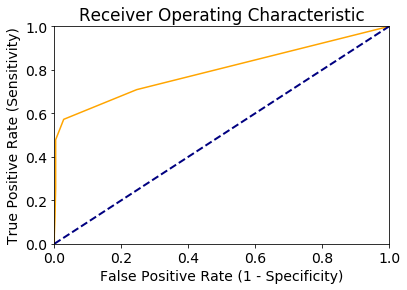

0.7240319204604919

In [69]:
roc(gs.best_estimator_.predict_proba(X_scrub_test), y_test)
roc_auc_score(gs.best_estimator_.predict(X_scrub_test), y_test)

Somewhat of a success, we are able to push further than our original model. The FPR still rises sharply.

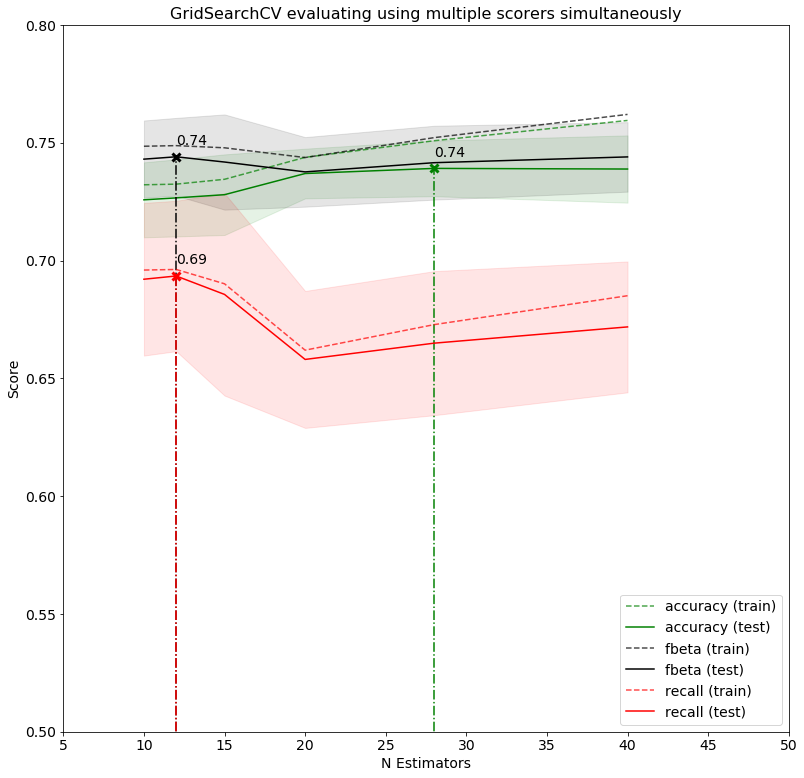

In [71]:
# Taken from Sklearn Docs
results = gs.cv_results_
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("N Estimators")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(5, 50)
ax.set_ylim(0.5, 0.8)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_n_estimators'].data, dtype=float)

for scorer, color in zip(sorted(scorers), ['g', 'k', 'r']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

So far, this 'simpler' model is winnning